# Influence of DFG conformation on structure distances

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from opencadd.databases.klifs import setup_local

from kissim.comparison import FingerprintDistanceGenerator

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../results/"

In [4]:
plt.style.use("seaborn")

In [5]:
%matplotlib inline

In [6]:
COVERAGE_CUTOFF = 0.8

## Load structural metadata

In [7]:
klifs_session = setup_local(HERE / "../../data/external/20210114_KLIFS_HUMAN/")
structures = klifs_session.structures.all_structures()

## Load fingerprint distances

In [8]:
fingerprint_distance_file = (
    DATA / "fingerprint_distances.csv"
)

In [9]:
fingerprint_distance_generator = FingerprintDistanceGenerator.from_csv(fingerprint_distance_file)
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")

Number of kinases: 292
Number of structures: 4916


In [10]:
structure_distances = fingerprint_distance_generator.data
structure_distances.head()

,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage
0,3835,6679,AAK1,AAK1,0.051608,0.992667
1,3835,7156,AAK1,AAK1,0.059276,0.991333
2,3835,1104,AAK1,ABL1,0.275259,0.990667
3,3835,1065,AAK1,ABL1,0.284854,0.990667
4,3835,1090,AAK1,ABL1,0.262851,0.990667


### Sort fingerprint/kinase pairs (alphabetically)

### Filter distances by coverage cutoff

In [11]:
structure_distances["distance_filtered"] = np.where(
    structure_distances["bit_coverage"].values < COVERAGE_CUTOFF,
    np.nan,
    structure_distances["distance"].values,
)
structure_distances.head()

,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage,distance_filtered
0,3835,6679,AAK1,AAK1,0.051608,0.992667,0.051608
1,3835,7156,AAK1,AAK1,0.059276,0.991333,0.059276
2,3835,1104,AAK1,ABL1,0.275259,0.990667,0.275259
3,3835,1065,AAK1,ABL1,0.284854,0.990667,0.284854
4,3835,1090,AAK1,ABL1,0.262851,0.990667,0.262851


In [12]:
print(f"Structure pairs: {structure_distances.shape[0]}")
structure_distances = structure_distances[structure_distances["distance_filtered"].notna()]
print(f"Structure pairs not-NaN: {structure_distances.shape[0]}")

Structure pairs: 12081070
Structure pairs not-NaN: 11964546


## DFG conformation

### Plot DFG-in vs. DFG-out

In [13]:
%%time
dfg = structures.set_index("structure.klifs_id")["structure.dfg"]
structure_distances["dfg.1"] = structure_distances["structure.1"].apply(lambda x: dfg[x])
structure_distances["dfg.2"] = structure_distances["structure.2"].apply(lambda x: dfg[x])

<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 1min 2s, sys: 371 ms, total: 1min 2s
Wall time: 1min 2s


<timed exec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
structure_distances.head()

,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage,distance_filtered,dfg.1,dfg.2
0,3835,6679,AAK1,AAK1,0.051608,0.992667,0.051608,in,in
1,3835,7156,AAK1,AAK1,0.059276,0.991333,0.059276,in,in
2,3835,1104,AAK1,ABL1,0.275259,0.990667,0.275259,in,out-like
3,3835,1065,AAK1,ABL1,0.284854,0.990667,0.284854,in,out
4,3835,1090,AAK1,ABL1,0.262851,0.990667,0.262851,in,in


In [16]:
structure_distances_dfg = {
    "all": structure_distances["distance_filtered"],
    "in/in": structure_distances[
        (structure_distances["dfg.1"] == "in") & (structure_distances["dfg.2"] == "in")
    ]["distance_filtered"],
    "out/out": structure_distances[
        (structure_distances["dfg.1"] == "out") & (structure_distances["dfg.2"] == "out")
    ]["distance_filtered"],
    "in/out": structure_distances[
        ((structure_distances["dfg.1"] == "in") & (structure_distances["dfg.2"] == "out"))
        | ((structure_distances["dfg.1"] == "out") & (structure_distances["dfg.2"] == "in"))
    ]["distance_filtered"],
}
structure_distances_dfg = pd.DataFrame(structure_distances_dfg)

In [17]:
structure_distances_dfg.notna().sum()

all        11964546
in/in       8986558
out/out       80675
in/out      1706654
dtype: int64

In [18]:
structure_distances_dfg.describe()

,all,in/in,out/out,in/out
count,1.196455e+07,8.986558e+06,80675.000000,1.706654e+06
mean,2.591149e-01,2.568413e-01,0.233366,2.609551e-01
std,6.416281e-02,6.517848e-02,0.065284,5.454680e-02
min,0.000000e+00,0.000000e+00,0.000000,1.266475e-02
25%,2.246006e-01,2.223800e-01,0.199945,2.305254e-01
50%,2.509275e-01,2.486435e-01,0.238215,2.545010e-01
75%,2.833567e-01,2.811818e-01,0.267869,2.831307e-01
max,6.492761e-01,6.359691e-01,0.513118,6.446349e-01


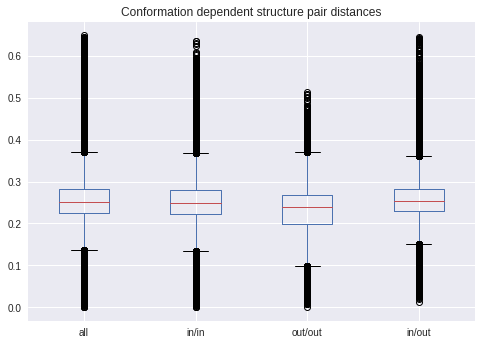

In [19]:
structure_distances_dfg.plot(kind="box", title="Conformation dependent structure pair distances");